In [1]:
import numpy as np
import pandas as pd
from sklearn import ensemble, neighbors, linear_model, metrics, preprocessing
from datetime import datetime

data = {
    'tra': pd.read_csv('../data/air_visit_data.csv'),
    'as': pd.read_csv('../data/air_store_info.csv'),
    'hs': pd.read_csv('../data/hpg_store_info.csv'),
    'ar': pd.read_csv('../data/air_reserve.csv'),
    'hr': pd.read_csv('../data/hpg_reserve.csv'),
    'id': pd.read_csv('../data/store_id_relation.csv'),
    'tes': pd.read_csv('../data/sample_submission.csv'),
    'hol': pd.read_csv('../data/date_info.csv').rename(columns={'calendar_date':'visit_date'})
    }

data['hr'] = pd.merge(data['hr'], data['id'], how='inner', on=['hpg_store_id'])

for df in ['ar','hr']:
    data[df]['visit_datetime'] = pd.to_datetime(data[df]['visit_datetime'])
    data[df]['visit_datetime'] = data[df]['visit_datetime'].dt.date
    data[df]['reserve_datetime'] = pd.to_datetime(data[df]['reserve_datetime'])
    data[df]['reserve_datetime'] = data[df]['reserve_datetime'].dt.date
    data[df]['reserve_datetime_diff'] = data[df].apply(lambda r: (r['visit_datetime'] - r['reserve_datetime']).days, axis=1)
    data[df] = data[df].groupby(['air_store_id','visit_datetime'], as_index=False)[['reserve_datetime_diff', 'reserve_visitors']].sum().rename(columns={'visit_datetime':'visit_date'})
    print(data[df].head())

data['tra']['visit_date'] = pd.to_datetime(data['tra']['visit_date'])
data['tra']['dow'] = data['tra']['visit_date'].dt.dayofweek
data['tra']['year'] = data['tra']['visit_date'].dt.year
data['tra']['month'] = data['tra']['visit_date'].dt.month
data['tra']['visit_date'] = data['tra']['visit_date'].dt.date

data['tes']['visit_date'] = data['tes']['id'].map(lambda x: str(x).split('_')[2])
data['tes']['air_store_id'] = data['tes']['id'].map(lambda x: '_'.join(x.split('_')[:2]))
data['tes']['visit_date'] = pd.to_datetime(data['tes']['visit_date'])
data['tes']['dow'] = data['tes']['visit_date'].dt.dayofweek
data['tes']['year'] = data['tes']['visit_date'].dt.year
data['tes']['month'] = data['tes']['visit_date'].dt.month
data['tes']['visit_date'] = data['tes']['visit_date'].dt.date

unique_stores = data['tes']['air_store_id'].unique()
stores = pd.concat([pd.DataFrame({'air_store_id': unique_stores, 'dow': [i]*len(unique_stores)}) for i in range(7)], axis=0, ignore_index=True).reset_index(drop=True)

#sure it can be compressed...
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].min().rename(columns={'visitors':'min_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow']) 
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].mean().rename(columns={'visitors':'mean_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].median().rename(columns={'visitors':'median_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].max().rename(columns={'visitors':'max_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].count().rename(columns={'visitors':'count_observations'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow']) 

stores = pd.merge(stores, data['as'], how='left', on=['air_store_id']) 
lbl = preprocessing.LabelEncoder()
stores['air_genre_name'] = lbl.fit_transform(stores['air_genre_name'])
stores['air_area_name'] = lbl.fit_transform(stores['air_area_name'])

data['hol']['visit_date'] = pd.to_datetime(data['hol']['visit_date'])
data['hol']['day_of_week'] = lbl.fit_transform(data['hol']['day_of_week'])
data['hol']['visit_date'] = data['hol']['visit_date'].dt.date
train = pd.merge(data['tra'], data['hol'], how='left', on=['visit_date']) 
test = pd.merge(data['tes'], data['hol'], how='left', on=['visit_date']) 

train = pd.merge(data['tra'], stores, how='left', on=['air_store_id','dow']) 
test = pd.merge(data['tes'], stores, how='left', on=['air_store_id','dow'])

for df in ['ar','hr']:
    train = pd.merge(train, data[df], how='left', on=['air_store_id','visit_date']) 
    test = pd.merge(test, data[df], how='left', on=['air_store_id','visit_date'])
    
print(train.describe())
print(train.head())

col = [c for c in train if c not in ['id', 'air_store_id','visit_date','visitors']]
train = train.fillna(-1)
test = test.fillna(-1)

def RMSLE(y, pred):
    return metrics.mean_squared_error(y, pred)**0.5

#lr = linear_model.LinearRegression(n_jobs=-1)
etc = ensemble.ExtraTreesRegressor(n_estimators=225, max_depth=5, n_jobs=-1, random_state=3)
knn = neighbors.KNeighborsRegressor(n_jobs=-1, n_neighbors=4)

           air_store_id  visit_date  reserve_datetime_diff  reserve_visitors
0  air_00a91d42b08b08d9  2016-10-31                      0                 2
1  air_00a91d42b08b08d9  2016-12-05                      4                 9
2  air_00a91d42b08b08d9  2016-12-14                      6                18
3  air_00a91d42b08b08d9  2016-12-17                      6                 2
4  air_00a91d42b08b08d9  2016-12-20                      2                 4
           air_store_id  visit_date  reserve_datetime_diff  reserve_visitors
0  air_00a91d42b08b08d9  2016-01-14                      3                 2
1  air_00a91d42b08b08d9  2016-01-15                      6                 4
2  air_00a91d42b08b08d9  2016-01-16                      3                 2
3  air_00a91d42b08b08d9  2016-01-22                      3                 2
4  air_00a91d42b08b08d9  2016-01-29                      6                 5
            visitors            dow           year          month  \
count  

In [2]:
from lib.ML_regression_util import UTIL
from lib.ML_regression_util import Model_GridSearchCV

In [3]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV

In [4]:
train_x,test_x,train_y,test_y = train_test_split(train[col], np.log1p(train['visitors'].values), test_size=0.33, random_state=42)

In [5]:
data=[train_x,test_x,train_y,test_y]
model=UTIL()
model.run_basic_models(data=data,model_list=['rf','gb','lasso','xtree','knn','enet'])


Working on model: enet
Fitting model enet, train MSE:0.632310,test MSE:0.638227
Working on model: lasso
Fitting model lasso, train MSE:0.649864,test MSE:0.653361
Working on model: rf
Fitting model rf, train MSE:0.130218,test MSE:0.306890
Working on model: gb
Fitting model gb, train MSE:0.256315,test MSE:0.258270
Working on model: xtree
Fitting model xtree, train MSE:0.121617,test MSE:0.351268
Working on model: knn
Fitting model knn, train MSE:0.181546,test MSE:0.298150


In [6]:
model_dict=model.model_dict
parameters_dict=model.parameters_dict
model=model_dict['lasso']
parameters=parameters_dict['lasso']
print(parameters)


{'lasso__alpha': [0.0001, 0.0005, 0.01, 0.05, 0.1, 0.5]}


0.513 (+/-0.039) for {'lasso__alpha': 0.0001}
0.513 (+/-0.039) for {'lasso__alpha': 0.0005}
0.513 (+/-0.032) for {'lasso__alpha': 0.01}
0.507 (+/-0.017) for {'lasso__alpha': 0.05}
0.487 (+/-0.005) for {'lasso__alpha': 0.1}
0.029 (+/-0.001) for {'lasso__alpha': 0.5}
trainset MSE= 0.309
testset MSE= 0.309


(Pipeline(steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
        with_scaling=True)), ('lasso', Lasso(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=1000,
    normalize=False, positive=False, precompute=False, random_state=None,
    selection='cyclic', tol=0.0001, warm_start=False))]),
 {'lasso__alpha': 0.0005})

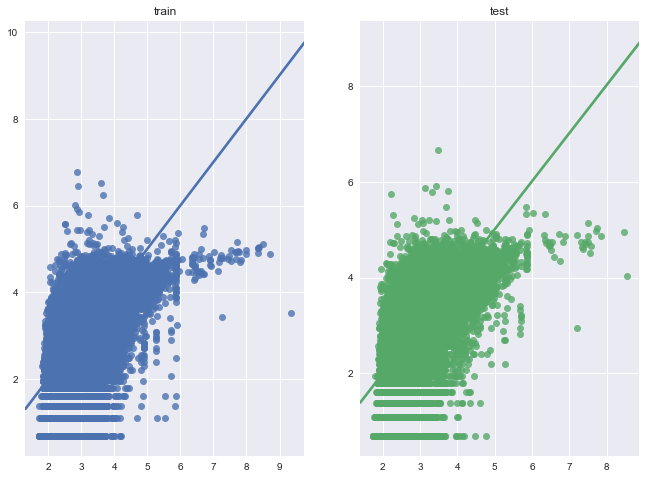

In [7]:
from sklearn.model_selection import KFold
n_folds=4
kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train_x.values)
Model_GridSearchCV(model,parameters,kf,data)

{'n_estimators': [100, 200], 'max_depth': [2, 3, 4]}
0.597 (+/-0.006) for {'max_depth': 2, 'n_estimators': 100}
0.601 (+/-0.006) for {'max_depth': 2, 'n_estimators': 200}
0.602 (+/-0.007) for {'max_depth': 3, 'n_estimators': 100}
0.604 (+/-0.007) for {'max_depth': 3, 'n_estimators': 200}
0.604 (+/-0.007) for {'max_depth': 4, 'n_estimators': 100}
0.606 (+/-0.006) for {'max_depth': 4, 'n_estimators': 200}
trainset MSE= 0.252
testset MSE= 0.256


(GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='ls', max_depth=4, max_features=None,
              max_leaf_nodes=None, min_impurity_split=1e-07,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False), {'max_depth': 4, 'n_estimators': 200})

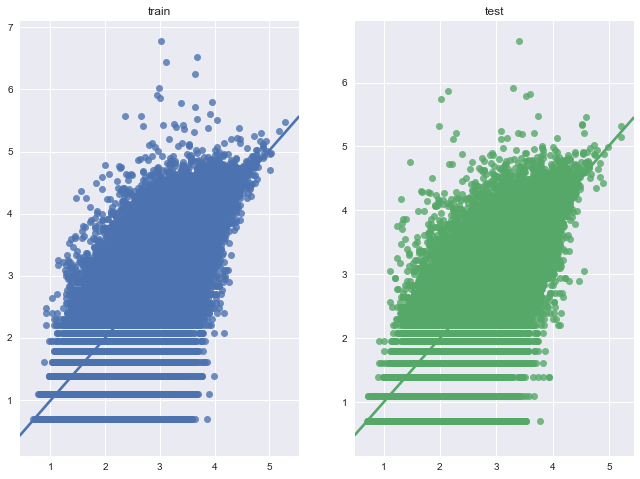

In [8]:
model=model_dict['gb']
parameters=parameters_dict['gb']
parameters['max_depth']=[2,3,4]
print(parameters)
Model_GridSearchCV(model,parameters,kf,data)

{'n_estimators': [10, 20]}
0.432 (+/-0.009) for {'n_estimators': 10}
0.435 (+/-0.007) for {'n_estimators': 20}
trainset MSE= 0.122
testset MSE= 0.351
{'n_estimators': [100, 200]}
0.523 (+/-0.005) for {'n_estimators': 100}
0.524 (+/-0.005) for {'n_estimators': 200}
trainset MSE= 0.130
testset MSE= 0.307


(RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False), {'n_estimators': 200})

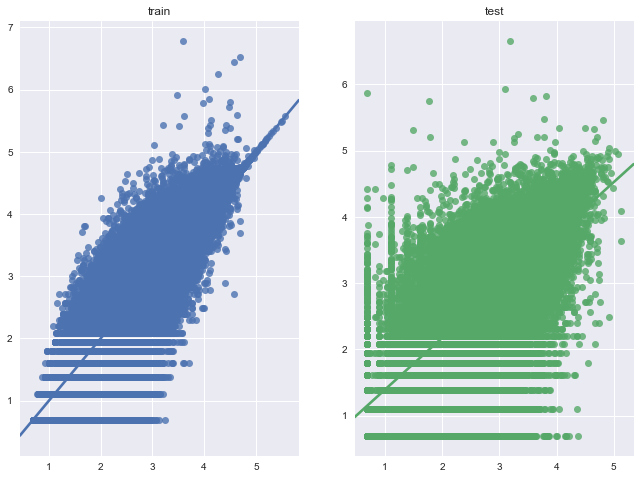

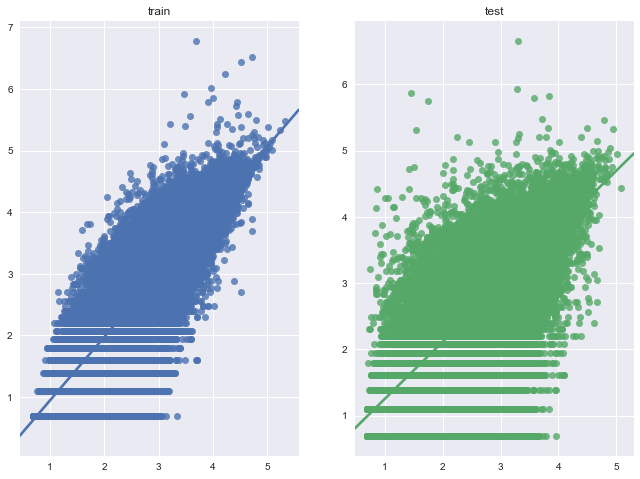

In [11]:
model=model_dict['xtree']
parameters=parameters_dict['xtree']
print(parameters)
Model_GridSearchCV(model,parameters,kf,data)
model=model_dict['rf']
parameters=parameters_dict['rf']
print(parameters)
Model_GridSearchCV(model,parameters,kf,data)

In [ ]:
model=model_dict['knn']
parameters=parameters_dict['knn']
print(parameters)
Model_GridSearchCV(model,parameters,kf,data)

0.506 (+/-0.001) for {'kneighborsregressor__n_neighbors': 3}
0.534 (+/-0.004) for {'kneighborsregressor__n_neighbors': 4}
trainset MSE= 0.182
testset MSE= 0.298


(Pipeline(steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
        with_scaling=True)), ('kneighborsregressor', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
           weights='uniform'))]), {'kneighborsregressor__n_neighbors': 4})

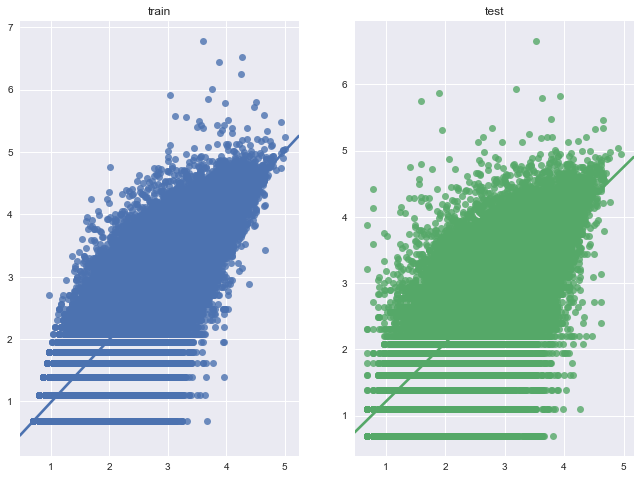

In [21]:
from sklearn.neighbors import KNeighborsRegressor
m=KNeighborsRegressor()
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
knn = make_pipeline(RobustScaler(), KNeighborsRegressor(n_jobs=-1, n_neighbors=4))
parameters={'kneighborsregressor__n_neighbors':[3,4]}
Model_GridSearchCV(knn,parameters,kf,data)

In [25]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0005))
rf = RandomForestRegressor(n_estimators=200,n_jobs=-1)
gb = GradientBoostingRegressor(n_estimators=200)
xtree=ExtraTreesRegressor(n_estimators=10,n_jobs=-1)
knn = make_pipeline(RobustScaler(), KNeighborsRegressor(n_jobs=-1, n_neighbors=4))
model_list=[lasso,rf,gb,xtree,knn]
model_name=['lasso','rf','gb','xtree','knn']

In [26]:
m_index=0
modelresult=[]
for model in model_list:
    model.fit(train[col], np.log1p(train['visitors'].values))
    print(model_name[m_index],' RMSE: ', RMSLE(np.log1p(train['visitors'].values), model.predict(train[col])))
    modelresult.append(model.predict(test[col]))
    m_index+=1


lasso  RMSE:  0.555946295979
rf  RMSE:  0.388443834202
gb  RMSE:  0.506067661334
xtree  RMSE:  0.381109581504
knn  RMSE:  0.428091437647


In [31]:
test['visitors'] = 0.2*modelresult[0]+0.15*modelresult[1]+0.25*modelresult[2]+0.15*modelresult[3]+0.25*modelresult[4]
test['visitors'] = np.expm1(test['visitors']).clip(lower=0.)
test[['id','visitors']].to_csv('0.2_0.15_0.25_0.15_0.25_submission.csv', index=False, float_format='%.2f')

In [ ]:
etc.fit(train[col], np.log1p(train['visitors'].values))
knn.fit(train[col], np.log1p(train['visitors'].values))
#print('RMSE LinearRegressor: ', RMSLE(np.log1p(train['visitors'].values), lr.predict(train[col])))
print('RMSE ExtraTreesRegressor: ', RMSLE(np.log1p(train['visitors'].values), etc.predict(train[col])))
print('RMSE KNNRegressor: ', RMSLE(np.log1p(train['visitors'].values), knn.predict(train[col])))

test['visitors'] = (etc.predict(test[col]) / 2) +(knn.predict(test[col]) / 2)
test['visitors'] = np.expm1(test['visitors']).clip(lower=0.)
test[['id','visitors']].to_csv('lr_submission.csv', index=False, float_format='%.2f')